In [1]:
import numpy as np
import os
import glob
import PIL.Image

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import optimizers

import pandas as pd
from pretty_confusion_matrix import pp_matrix

In [2]:
IMAGE_SIZE = (400, 150, 3)
RESIZED_SIZE = (100, 50, 3)
RESIZED_SIZE_PIL = (RESIZED_SIZE[1], RESIZED_SIZE[0], RESIZED_SIZE[2])
DATASET_PATH = "./dataset_rot/"
DATASET_PATH = os.path.abspath(DATASET_PATH)
CLASSES = next(os.walk(DATASET_PATH))[1]

print(DATASET_PATH)
print(CLASSES)

VALIDATION_SPLIT = 0.15
TEST_SPLIT = 0.15

BATCH_SIZE = 32
EPOCHS = 25

RANDOM_SEED = 2


/tmp/deepl/dataset_rot
['octane', 'werewolf', 'breakout', 'aftershock']


In [3]:
def load_data():
    # Récupération des fichiers
    files = glob.glob(f"{DATASET_PATH}/**/*.jpg", recursive=True)

    # Initialise les structures de données
    x = np.zeros((len(files), *RESIZED_SIZE_PIL))
    y = np.zeros((len(files), 1))

    # print(f"x.shape = {x.shape}")

    for i, path in enumerate(files):
        # Lecture de l'image
        img = PIL.Image.open(path)

        # print(f"img.size = {img.size}")

        # Redimensionnement de l'image
        img = img.resize(RESIZED_SIZE[:-1], PIL.Image.ANTIALIAS)

        # print(f"img.size = {img.size}")

        test = np.asarray(img)

        # print(f"test.shape = {test.shape}")

        # Remplissage de la variable x
        x[i] = test

        # On récupère l'index dans le path
        class_label = path.split("/")[-2]

        # On récupère le numéro de la classe à partir du string
        class_label = CLASSES.index(class_label)

        # Remplissage de la variable y
        y[i] = class_label

    return x, y


In [4]:
x, y = load_data()
x = x / 255

# shuffle dataset
size = len(y)
indices = np.arange(size)
np.random.seed(RANDOM_SEED)
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

# split dataset
test_size = int(TEST_SPLIT * size)
x_test = x[:test_size]
y_test = y[:test_size]

validation_size = int(VALIDATION_SPLIT * size)
x_validation = x[test_size:test_size+validation_size]
y_validation = y[test_size:test_size+validation_size]

x_train = x[test_size+validation_size:]
y_train = y[test_size+validation_size:]


/tmp/ipykernel_1252529/2192415425.py:18: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize(RESIZED_SIZE[:-1], PIL.Image.ANTIALIAS)


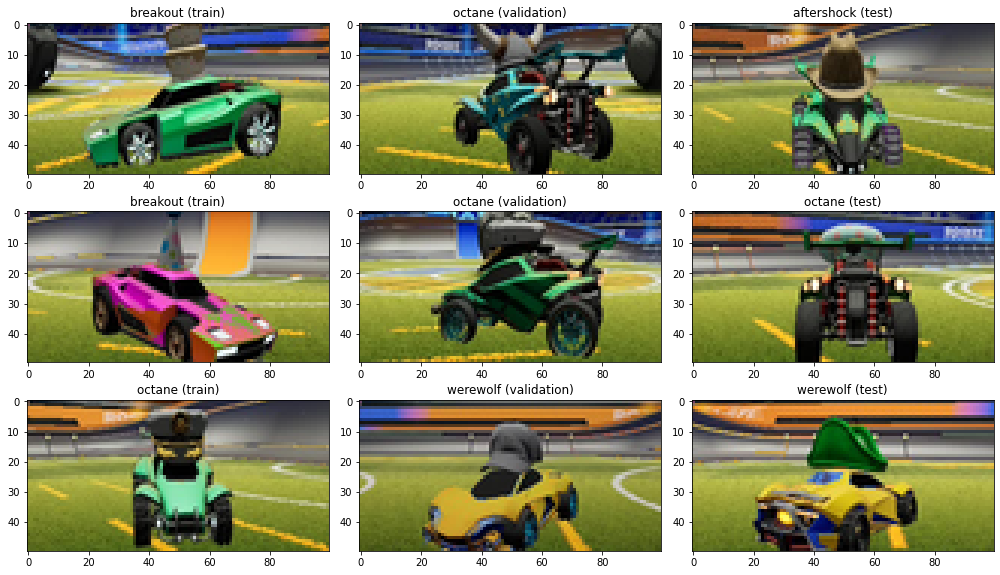

In [5]:
plt.figure(figsize=(14, 8))

for i in range(3):
    # train image
    plt.subplot(3, 3, 3*i + 1)
    plt.title(CLASSES[int(y_train[i])] + " (train)")
    plt.imshow(x_train[i])
    
    # validation image
    plt.subplot(3, 3, 3*i + 2)
    plt.title(CLASSES[int(y_validation[i])] + " (validation)")
    plt.imshow(x_validation[i])
    
    # test image
    plt.subplot(3, 3, 3*i + 3)
    plt.title(CLASSES[int(y_test[i])] + " (test)")
    plt.imshow(x_test[i])

plt.tight_layout()
plt.show()


In [6]:
# build the model
model = Sequential(
    [
        InputLayer(input_shape=RESIZED_SIZE_PIL),
        Conv2D(32, 3, activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, 3, activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(92, 3, activation="relu", name="conv2d_last"),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(250, activation="relu"),
        Dense(4, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 49, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_last (Conv2D)        (None, 9, 21, 92)         53084     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 10, 92)        0

2022-05-04 15:39:59.110288: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-04 15:39:59.745388: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1538 MB memory:  -> device: 0, name: Quadro K620, pci bus id: 0000:03:00.0, compute capability: 5.0


In [7]:
# train the model on the dataset
adam = optimizers.Adam(learning_rate=7e-6)
model.compile(optimizer=adam, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), epochs=EPOCHS, batch_size=BATCH_SIZE)


Epoch 1/25


2022-05-04 15:40:01.292533: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2022-05-04 15:40:01.725016: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


88/88 [==============================] - 7s 53ms/step - loss: 1.3774 - accuracy: 0.2975 - val_loss: 1.3620 - val_accuracy: 0.5167
Epoch 2/25
88/88 [==============================] - 4s 44ms/step - loss: 1.3499 - accuracy: 0.5782 - val_loss: 1.3347 - val_accuracy: 0.5983
Epoch 3/25
88/88 [==============================] - 4s 44ms/step - loss: 1.3176 - accuracy: 0.6268 - val_loss: 1.2968 - val_accuracy: 0.6833
Epoch 4/25
88/88 [==============================] - 4s 44ms/step - loss: 1.2726 - accuracy: 0.7161 - val_loss: 1.2446 - val_accuracy: 0.7167
Epoch 5/25
88/88 [==============================] - 4s 44ms/step - loss: 1.2080 - accuracy: 0.7632 - val_loss: 1.1711 - val_accuracy: 0.8217
Epoch 6/25
88/88 [==============================] - 4s 44ms/step - loss: 1.1235 - accuracy: 0.8404 - val_loss: 1.0795 - val_accuracy: 0.7867
Epoch 7/25
88/88 [==============================] - 4s 43ms/step - loss: 1.0240 - accuracy: 0.8404 - val_loss: 0.9774 - val_accuracy: 0.8350
Epoch 8/25
88/88 [======

In [8]:
# Save the weights
model.save(f"models/rot_{EPOCHS}e")

2022-05-04 15:41:40.336042: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/rot_25e/assets


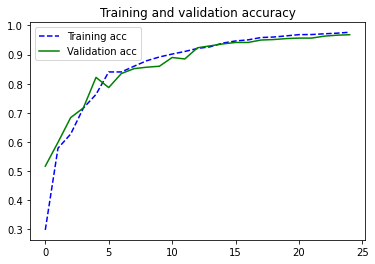

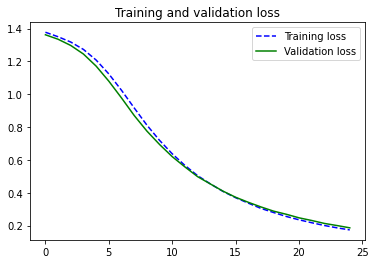

In [9]:
def plot_training_analysis():
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs = range(len(loss))

    plt.plot(epochs, acc, "b", linestyle="--", label="Training acc")
    plt.plot(epochs, val_acc, "g", label="Validation acc")
    plt.title("Training and validation accuracy")
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, "b", linestyle="--", label="Training loss")
    plt.plot(epochs, val_loss, "g", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()

    plt.show()


plot_training_analysis()


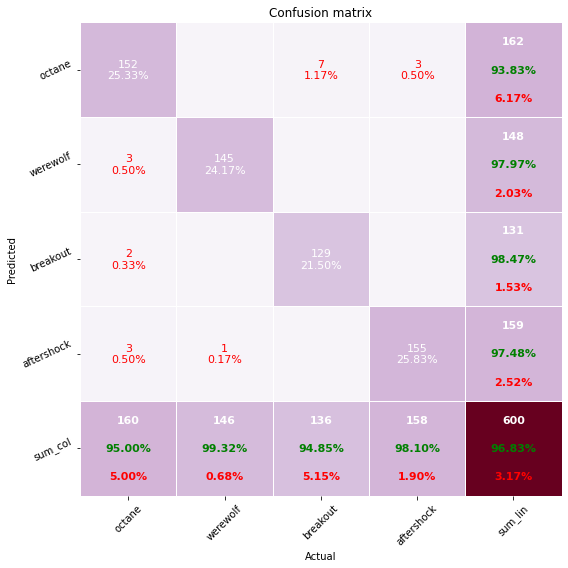

In [11]:
# création des prédictions sur les données de test
prediction = model.predict(x_test)
prediction = np.argmax(prediction, axis=1)
res = tf.math.confusion_matrix(y_test, prediction)

# get pandas dataframe
df_cm = pd.DataFrame(res, CLASSES, CLASSES)

# pretty_confusion_matrix
pp_matrix(df_cm, cmap="PuRd")

In [75]:
def make_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    return heatmap.numpy()

In [78]:
def make_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.004):

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = plt.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    return superimposed_img


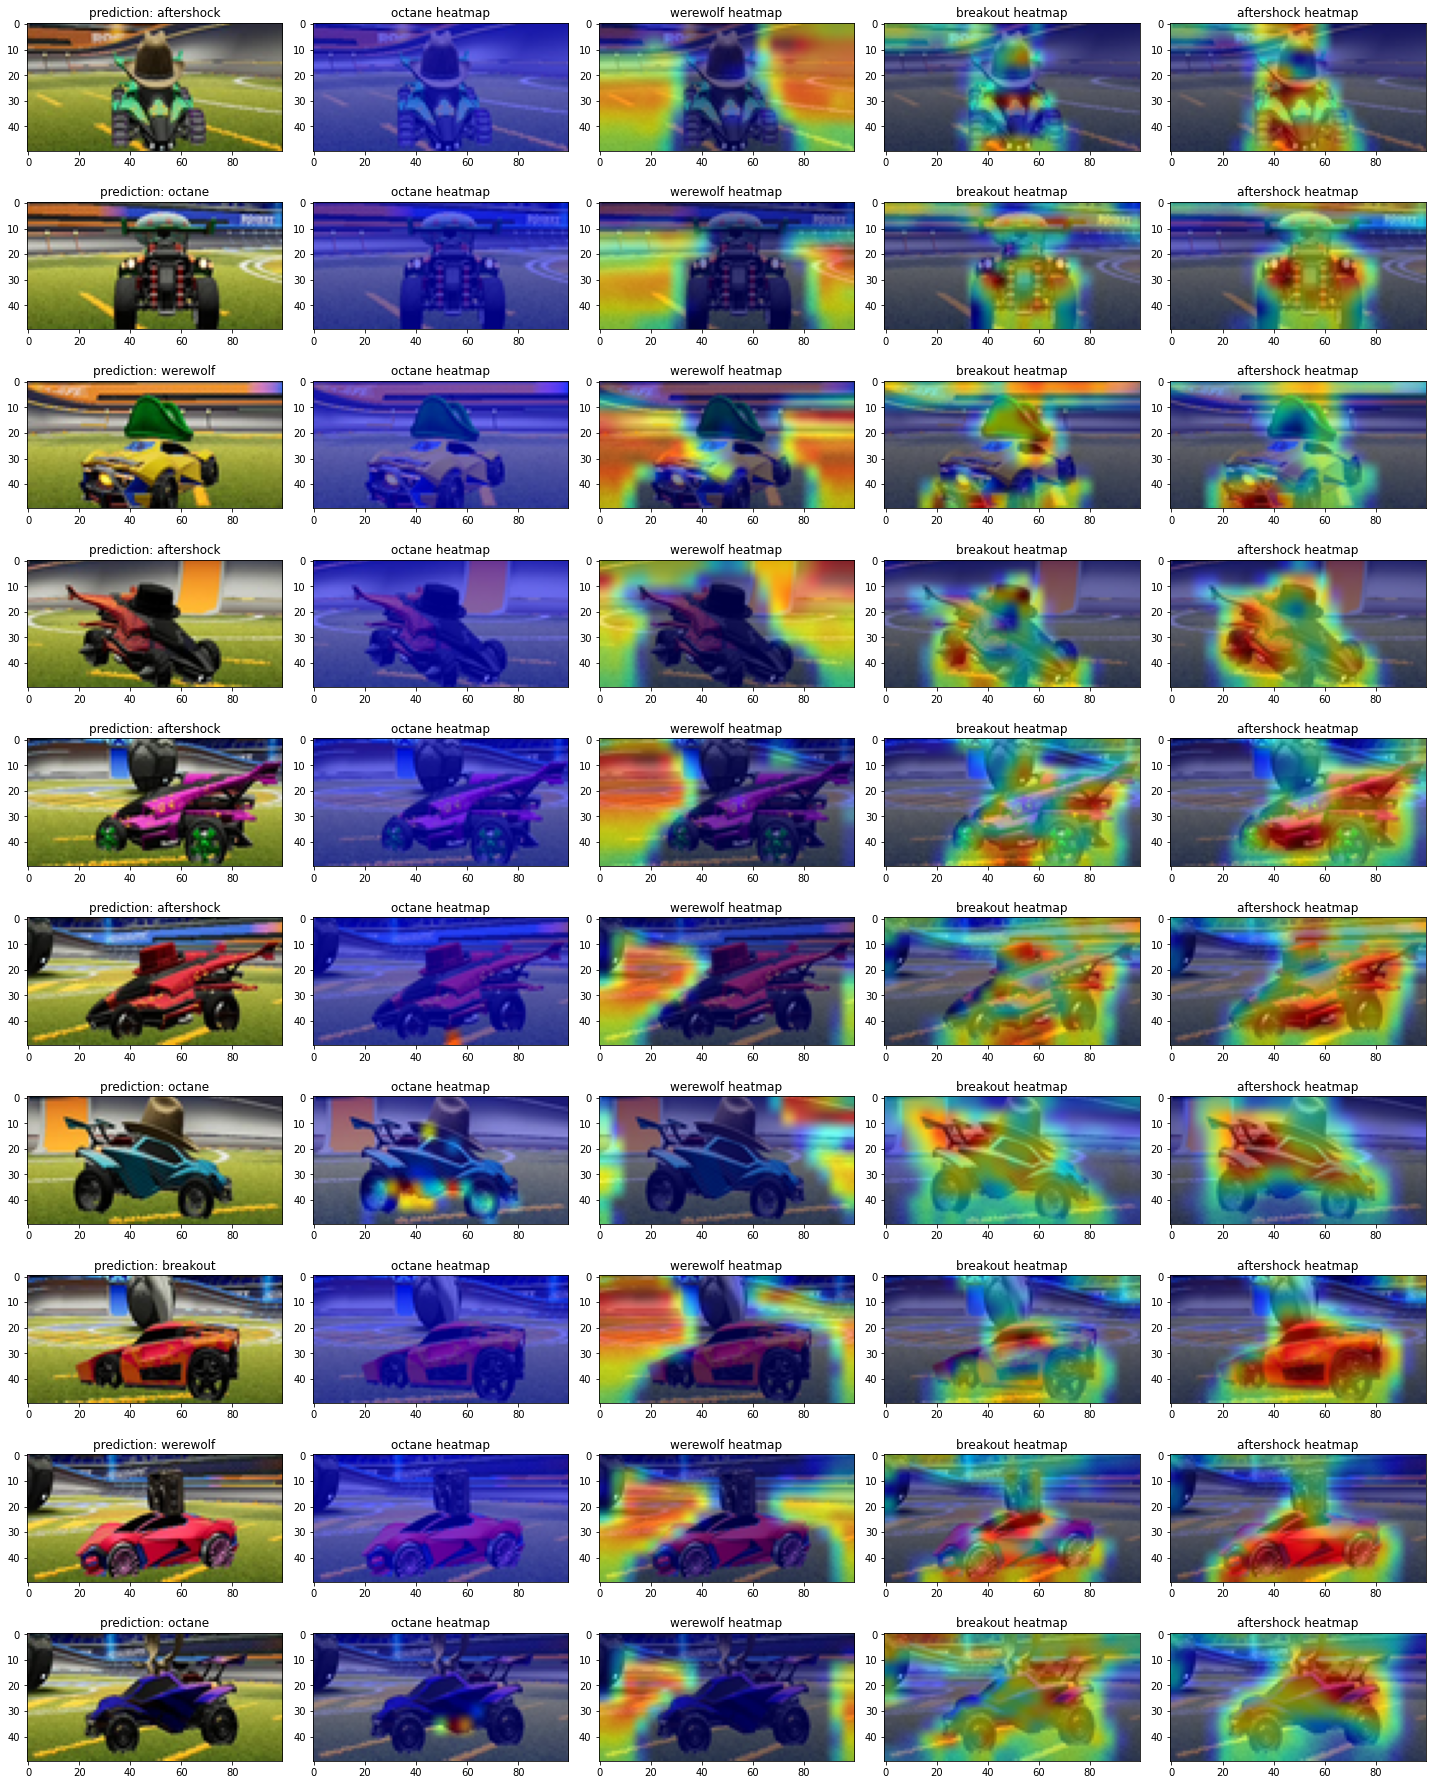

In [79]:
last_conv_layer_name = "conv2d_last"
plt.figure(figsize=(20, 25))

for i in range(10):

    img = x_test[i]

    X = np.zeros((1, RESIZED_SIZE[1], RESIZED_SIZE[0], RESIZED_SIZE[2]))
    X[0] = np.asarray(img)

    # Print what the top predicted class is
    preds = model.predict(X)
    index = np.argmax(preds)

    plt.subplot(10, 5, 5*i+1)
    plt.imshow(img)
    plt.title(f"prediction: {CLASSES[index]}")

    for j in range(4):
        # generate class activation heatmap
        heatmap = make_heatmap(X, model, last_conv_layer_name, pred_index=j)
        # generate gradmap
        gradcam = make_gradcam(img, heatmap)
        
        plt.subplot(10, 5, 5*i+j+2)
        plt.imshow(gradcam)
        plt.title(f"{CLASSES[j]} heatmap")

plt.tight_layout()
plt.show()
